In [30]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from shapely.geometry import box, Point
import random

def generate_random_points_within_gdf(maritime_gdf, num_points):
    """
    maritime GeoDataFrame 내에 랜덤 포인트를 생성합니다.
    
    Parameters:
        maritime_gdf (GeoDataFrame): maritime 영역의 GeoDataFrame
        num_points (int): 생성할 랜덤 포인트의 개수
    
    Returns:
        List[Point]: 생성된 랜덤 포인트 리스트
    """
    # maritime 영역의 전체 경계 가져오기
    minx, miny, maxx, maxy = maritime_gdf.total_bounds
    
    points = []
    attempts = 0
    max_attempts = num_points * 10  # 무한 루프 방지를 위한 최대 시도 횟수

    while len(points) < num_points and attempts < max_attempts:
        # 경계 박스 내에서 랜덤 좌표 생성
        random_lon = random.uniform(minx, maxx)
        random_lat = random.uniform(miny, maxy)
        point = Point(random_lon, random_lat)
        # 생성된 포인트가 maritime 영역 내에 있는지 확인
        if maritime_gdf.contains(point).any():
            points.append(point)
        attempts += 1

    if len(points) < num_points:
        print(f"Warning: Only {len(points)} points were generated after {attempts} attempts.")
    
    return points

def generate_random_points_within_bbox(bbox: box, num_points):
    """
    Generate random points within a given bounding box.

    Parameters:
        bbox (box): Bounding box within which to generate points.
        num_points (int): Number of random points to generate.

    Returns:
        List[Point]: List of generated random points.
    """
    minx, miny, maxx, maxy = bbox.bounds
    
    points = []
    for _ in range(num_points):
        random_lon = random.uniform(minx, maxx)
        random_lat = random.uniform(miny, maxy)
        points.append(Point(random_lon, random_lat))
    
    return points

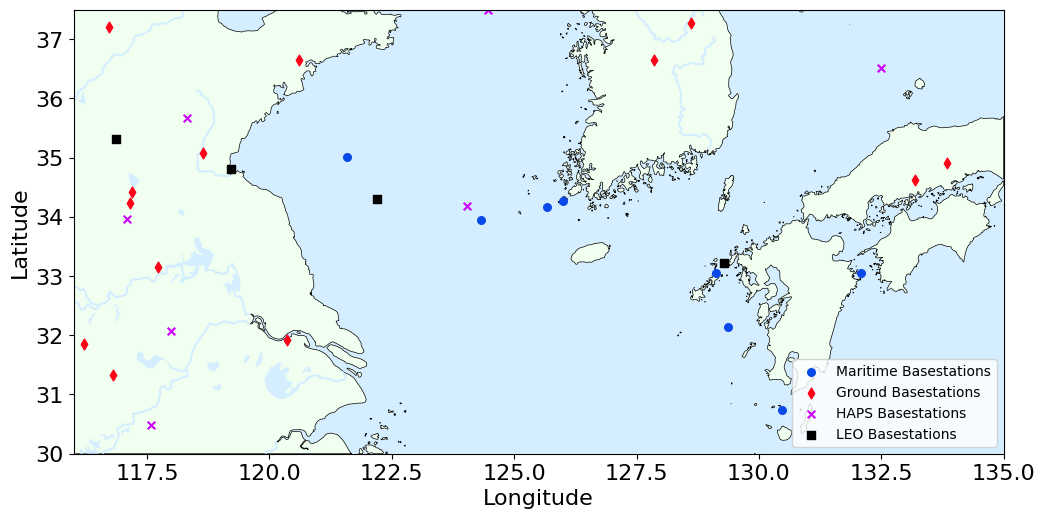

In [44]:
# Set configurations
fontsize=16
markersize=30
target_crs = "EPSG:4326"
langitude_range = [116, 135]
longitude_range = [30, 37.5]

land_color = np.array([240, 255, 240]) / 255.0
water_color = np.array([212, 238, 255]) / 255.0
edge_color = np.array([0, 0, 0]) / 255.0

num_maritime_basestations = 8
num_ground_basestations = 13
num_haps_basestations = 7
num_leo_basestations = 4

maritime_basestations_color = np.array([9, 72, 233]) / 255.0
ground_basestations_color = np.array([255, 0, 25]) / 255.0
haps_basestations_color = np.array([205, 0, 255]) / 255.0
leo_basestations_color = np.array([0, 0, 0]) / 255.0

# 관심 영역의 경계 박스 생성 (경도: 120~150, 위도: 30~45)
bbox = box(minx=langitude_range[0], miny=longitude_range[0], maxx=langitude_range[1], maxy=longitude_range[1])
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs=target_crs)

# 데이터 경로 설정
land_shp = "map/ne_10m_land/ne_10m_land.shp"
lakes_shp = "map/ne_10m_lakes/ne_10m_lakes.shp"
rivers_shp = "map/ne_10m_rivers_lake_centerlines/ne_10m_rivers_lake_centerlines.shp"
coastline_shp = "map/ne_10m_coastline/ne_10m_coastline.shp"
maritime_shp = "map/ne_10m_ocean/ne_10m_ocean.shp"

# GeoDataFrame으로 읽기
land = gpd.read_file(land_shp)
lakes = gpd.read_file(lakes_shp)
rivers = gpd.read_file(rivers_shp)
coastline = gpd.read_file(coastline_shp)
maritime = gpd.read_file(maritime_shp)  # maritime 데이터 불러오기

# 모든 GeoDataFrame이 동일한 CRS를 사용하는지 확인하고, 필요 시 변환
for df in [land, lakes, rivers, coastline, maritime]:
    if df.crs != target_crs:
        df.to_crs(target_crs, inplace=True)

# GeoPandas의 clip 함수를 사용하여 데이터를 경계 박스 내로 자르기
def clip_to_bbox(gdf, bbox):
    return gpd.clip(gdf, bbox)

maritime_filtered = clip_to_bbox(maritime, bbox_gdf)
land_filtered = clip_to_bbox(land, bbox_gdf)
lakes_filtered = clip_to_bbox(lakes, bbox_gdf)
rivers_filtered = clip_to_bbox(rivers, bbox_gdf)
coastline_filtered = clip_to_bbox(coastline, bbox_gdf)

maritime_basestations_points = generate_random_points_within_gdf(maritime_filtered, num_maritime_basestations)
ground_basestations_points = generate_random_points_within_gdf(land_filtered, num_ground_basestations)
haps_basestations_points = generate_random_points_within_bbox(bbox, num_haps_basestations)
leo_basestations_points = generate_random_points_within_bbox(bbox, num_leo_basestations)

# 9. GeoDataFrame으로 변환
maritime_basestations_gdf = gpd.GeoDataFrame({'geometry': maritime_basestations_points}, crs=target_crs)
ground_basestations_gdf = gpd.GeoDataFrame({'geometry': ground_basestations_points}, crs=target_crs)
haps_basestations_gdf = gpd.GeoDataFrame({'geometry': haps_basestations_points}, crs=target_crs)
leo_basestations_gdf = gpd.GeoDataFrame({'geometry': leo_basestations_points}, crs=target_crs)

# 시각화
fig, ax = plt.subplots(figsize=(12, 8))

# 그리는 순서: maritime -> Land -> Lakes -> Rivers -> Coastline
if not maritime_filtered.empty:
    maritime_filtered.plot(ax=ax, color=water_color, zorder=1)
if not land_filtered.empty:
    land_filtered.plot(ax=ax, color=land_color, edgecolor=edge_color, linewidth=.5, zorder=1)
if not lakes_filtered.empty:
    lakes_filtered.plot(ax=ax, color=water_color, zorder=1)
if not rivers_filtered.empty:
    rivers_filtered.plot(ax=ax, color=water_color, zorder=1)
# if not coastline_filtered.empty:
#     coastline_filtered.plot(ax=ax, color='black', linewidth=.75,)  # Coastline

maritime_basestations_gdf.plot(ax=ax, 
                            color=maritime_basestations_color,
                            marker="o",
                            markersize=markersize,
                            label='Maritime Basestations',
                            zorder=2)
ground_basestations_gdf.plot(ax=ax,
                            color=ground_basestations_color,
                            marker="d",
                            markersize=markersize,
                            label='Ground Basestations',
                            zorder=2)
haps_basestations_gdf.plot(ax=ax,
                           color=haps_basestations_color,
                           marker="x",
                           markersize=markersize,
                           label='HAPS Basestations',
                           zorder=2)
leo_basestations_gdf.plot(ax=ax,
                          color=leo_basestations_color,
                          marker="s",
                          markersize=markersize,
                          label='LEO Basestations',
                          zorder=2)

# 플롯의 축 범위를 경계 박스로 설정
plt.xlim(*langitude_range)
plt.ylim(*longitude_range)

# 제목 및 범례 추가
plt.xlabel('Longitude', fontsize=fontsize)
plt.ylabel('Latitude', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend()
plt.show()